In [17]:
import numpy as np 
import pandas as pd 
import os, time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten MaxPool2D, BatchNormalization, AveragePooling2D 

import os
from tqdm import tqdm

In [68]:
train_data_kaggle=np.load('./kaggledatasetlettermask.npy').reshape(-1,10000)
train_labels_kaggle=np.load('./kaggledatasetlettermasklabels.npy')

In [78]:
SIZE = 500
IMAGE_SIZE = 100

In [70]:
train_data_kaggle = train_data_kaggle.reshape(-1,100,100)
print(train_data_kaggle.shape)

(13000, 100, 100)


In [71]:
import os
path='./LetterDataset'
for i in tqdm(range(36)):
    temppath=os.path.join(path,str(i)+'/data_binary.npy')
    label=np.zeros((SIZE,36))
    label[:,i]=1
    train_data=np.load(temppath)
    train_data = train_data[0:SIZE]
    train_data_kaggle = np.vstack((train_data_kaggle,train_data))
    train_labels_kaggle = np.vstack((train_labels_kaggle,label))

100%|██████████| 36/36 [00:18<00:00,  1.90it/s]


In [72]:
X = np.repeat(train_data_kaggle[..., np.newaxis], 3, -1)
print(train_labels_kaggle.shape)
X.shape

(31000, 36)


(31000, 100, 100, 3)

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


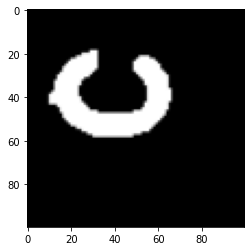

In [75]:
plt.imshow(X[1000])
print(train_labels_kaggle[1000])

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X,train_labels_kaggle, test_size=0.1, random_state=42, shuffle=True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(27900, 100, 100, 3) (3100, 100, 100, 3) (27900, 36) (3100, 36)


In [83]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
model = Sequential()
model.add(Xception(include_top = False, pooling = MaxPool2D,input_shape= input_shape, weights = 'imagenet'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1024, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(36, activation = 'softmax'))

In [84]:
model.summary()
optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay = 0.0)
model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 18432)             73728     
_________________________________________________________________
dropout_3 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              18875392  
_________________________________________________________________
batch_normalization_11 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_5 (Dense)              (None, 512)              

In [85]:
EPOCHS = 50
BATCH_SIZE = 64
annealer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                                                patience=10, verbose=1, min_lr=1e-5)
checkpoint = tf.keras.callbacks.ModelCheckpoint('full_train_xception.h5', verbose=1,
                                                save_best_only=True)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360,
                        width_shift_range=0.1, height_shift_range=0.1, 
                        zoom_range=0.2, horizontal_flip=True, vertical_flip=True) 

datagen.fit(X_train)

history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE, epochs=EPOCHS,verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_test, y_test))

Epoch 1/50
435/435 [==============================] - 118s 249ms/step - loss: 3.9279 - accuracy: 0.0485 - val_loss: 2.7784 - val_accuracy: 0.2735

Epoch 00001: val_loss improved from inf to 2.77843, saving model to full_train_xception.h5
Epoch 2/50
435/435 [==============================] - 91s 209ms/step - loss: 2.8178 - accuracy: 0.2444 - val_loss: 1.9735 - val_accuracy: 0.4700

Epoch 00002: val_loss improved from 2.77843 to 1.97350, saving model to full_train_xception.h5
Epoch 3/50
435/435 [==============================] - 93s 215ms/step - loss: 2.0328 - accuracy: 0.4534 - val_loss: 1.4196 - val_accuracy: 0.6123

Epoch 00003: val_loss improved from 1.97350 to 1.41964, saving model to full_train_xception.h5
Epoch 4/50
435/435 [==============================] - 91s 209ms/step - loss: 1.6462 - accuracy: 0.5548 - val_loss: 1.2729 - val_accuracy: 0.6455

Epoch 00004: val_loss improved from 1.41964 to 1.27291, saving model to full_train_xception.h5
Epoch 5/50
435/435 [===================